# Diffusion models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import sys

from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
from tqdm import tqdm

project_root = Path().absolute().parent
sys.path.append(str(project_root))
project_root

PosixPath('/home/aorellan/DiffusionArcade')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from src.diffusion.model import login_huggingface

login_huggingface()

#### Utils to show images and make grids

In [5]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

### Dataset

In [6]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# We'll train on 32-pixel square images
image_size = 32
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

X shape: torch.Size([8, 3, 32, 32])


/tmp/2631166/ipykernel_384475/2817422160.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


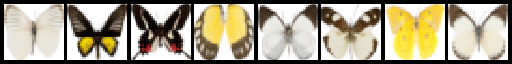

In [7]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

## Diffusion model

#### Forward diffusion process

In [8]:
from diffusers import DDIMScheduler # We can also use DDPM scheduler, but this is slower

timesteps = 1000

schedulers = {
    "cosine": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="squaredcos_cap_v2"
    ),
    "linear": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="linear"
    ),
}

The forward diffusion process progressively adds noise to the original image $\mathbf{x}_0$ as timestep $t$ increases.

The process is defined by the re-parameterization formula:

$$
q(\mathbf{x}_t \mid \mathbf{x}_0)
    = \mathcal{N}\!\bigl(
        \mathbf{x}_t;\,
        \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\,
        (1 - \bar{\alpha}_t)\,\mathbf{I}
      \bigr)
$$

where:

* $\mathbf{x}_t$ — noisy image at timestep $t$  
* $\sqrt{\bar{\alpha}_t}$ — scales down the original image  
* $1-\bar{\alpha}_t$ — variance of the added Gaussian noise

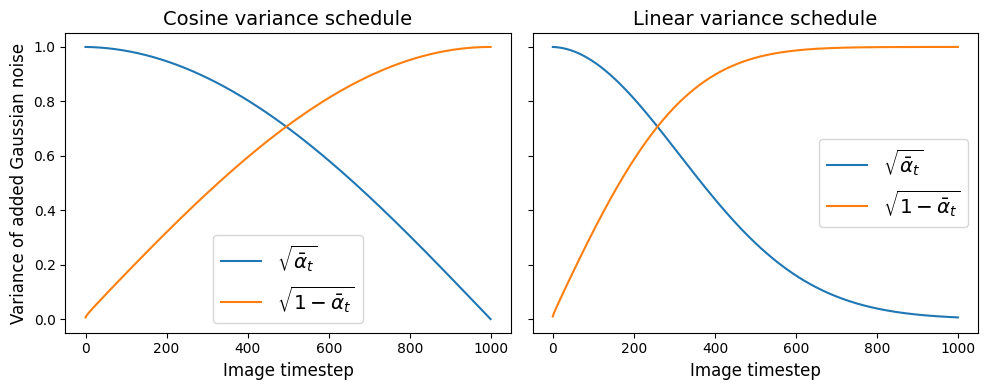

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, (name, sched) in zip(axes, schedulers.items()):
    alphas_cumprod = sched.alphas_cumprod.cpu()
    
    ax.plot(
        alphas_cumprod ** 0.5,
        label=r"$\sqrt{\bar{\alpha}_t}$"
    )
    ax.plot(
        (1 - alphas_cumprod) ** 0.5,
        label=r"$\sqrt{1 - \bar{\alpha}_t}$"
    )
    ax.set_title(f"{name.capitalize()} variance schedule", fontsize=14)
    ax.set_xlabel("Image timestep", fontsize=12)
    ax.legend(fontsize="x-large")
    
axes[0].set_ylabel("Variance of added Gaussian noise", fontsize=12)

plt.tight_layout()
plt.show()

The more time steps, the more noise is added to the original image $\mathbf{x}_0$

In [10]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

The following images demonstrate the progressive addition of noise to the original image $\mathbf{x}_0$ across different timesteps. The sequence shows a gradual transition from minimal noise in the initial images to almost complete noise in the final image.

Noisy X shape torch.Size([8, 3, 32, 32])


/tmp/2631166/ipykernel_384475/2817422160.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


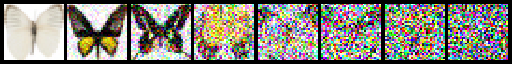

In [11]:
noise = torch.randn_like(xb) # same shape as xb: [Batch size, Channels, Height, Width]

noisy_xb = schedulers["cosine"].add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

#### Training

In [12]:
from src.diffusion.model import DiffusionModel

In [13]:
image_size = 32
in_channels = 3
out_channels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
timesteps = 1000

model = DiffusionModel(
    image_size=image_size,
    in_channels=in_channels,
    out_channels=out_channels,
    device=device,
    timesteps=timesteps,
    beta_schedule="squaredcos_cap_v2",
)

In [14]:
epochs = 30
lr = 4e-4

losses = model.train(train_dataloader, epochs=epochs, lr=lr)

Epoch 1/30:   0%|                                                                                                                                 | 0/16 [00:00<?, ?it/s]/home/aorellan/miniconda3/envs/diffusion_arcade/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s, loss=0.13]


Epoch [2/30] Average Loss: 0.1567


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s, loss=0.115]


Epoch [4/30] Average Loss: 0.1139


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s, loss=0.1]


Epoch [6/30] Average Loss: 0.0980


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s, loss=0.0627]


Epoch [8/30] Average Loss: 0.0930


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s, loss=0.0584]


Epoch [10/30] Average Loss: 0.0834


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s, loss=0.0784]


Epoch [12/30] Average Loss: 0.0745


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s, loss=0.0524]


Epoch [14/30] Average Loss: 0.0713


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s, loss=0.0541]


Epoch [16/30] Average Loss: 0.0611


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s, loss=0.055]


Epoch [18/30] Average Loss: 0.0640


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s, loss=0.0504]


Epoch [20/30] Average Loss: 0.0665


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s, loss=0.0573]


Epoch [22/30] Average Loss: 0.0594


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s, loss=0.0497]


Epoch [24/30] Average Loss: 0.0609


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s, loss=0.0846]


Epoch [26/30] Average Loss: 0.0625


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s, loss=0.0783]


Epoch [28/30] Average Loss: 0.0557


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s, loss=0.0809]

Epoch [30/30] Average Loss: 0.0630


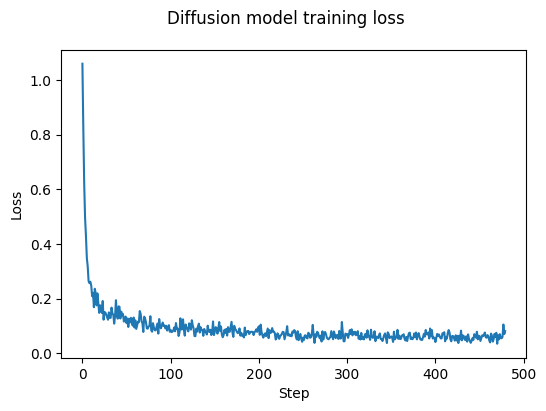

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Diffusion model training loss")

ax.plot(losses)
ax.set_xlabel("Step")
ax.set_ylabel("Loss")

plt.show()

#### Generation

/tmp/2631166/ipykernel_384475/2817422160.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


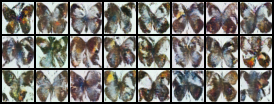

In [19]:
n_images = 24
n_channels = 3
num_inference_steps = 100

sample =model.generate(n_images, n_channels, num_inference_steps)

show_images(sample)

## References

1. **Hugging Face Diffusion Course, Unit 0: Introduction to Diffusion Models**  
   Available online: [https://huggingface.co/learn/diffusion-course/en/unit0/1](https://huggingface.co/learn/diffusion-course/en/unit0/1)

2. **Ho, J., Jain, A., & Abbeel, P.** (2020). *Denoising Diffusion Probabilistic Models*.  
   arXiv preprint arXiv:2006.11239. [PDF](https://arxiv.org/pdf/2006.11239)

3. **Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B.** (2022). *High-Resolution Image Synthesis with Latent Diffusion Models*.  
   arXiv preprint arXiv:2208.11970. [PDF](https://arxiv.org/pdf/2208.11970)
